## Summary 

Author: Trenton Bricken

Running all of the autoassociative SDM Experiments that don't involve learning the projection matrix for the Random Pattern and MNIST datasets. Uses Pytorch and has built in GPU compatibility to accelerate training. 

In [1]:
%load_ext autoreload
%autoreload 2
from Implementations_Associative_Memory import *
from Data_Processing_Associative_Memory import *
from SDM_Circ_Inter_Funcs import *
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch.nn.functional as F
import copy
from types import SimpleNamespace
#torch.cuda.set_device(3) 

In [4]:
data_name = "MNIST" #"MNIST" "RandUnif64" "RandUnif1000"
n_datasets = 3
n_perturb_repeats = 5 # number of unique perturbations when testing each data point
m=batch_size=1024 # this is the size of the dataset and also the batch size. Be careful if making m much larger. 

use_Neuron_SDM = False # will significantly reduce the number of neurons available.
if use_Neuron_SDM:
    assert data_name == "RandUnif64", "Wrong dataname for using NeuronSDM"

directory = 'figures/PerturbResults/'
num_workers = 4

print_each_result = False
rad = 1 # circle radius size. L2 unit norm. for continuous intersection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_perturbs = 7# number of perturbations to apply. 
max_conv_steps = 100 # for convergence of each query. 

'''
# Full list of algorithms
[Binary_Neuron_SDM, Binary_SDM, Binary_SDM_NeuronLimit,
Binary_SDM_BFit_Attention,
Cont_SDM, Cont_SDM_NeuronLimit, Cont_Binary_SDM, Cont_SDM_BFit_Attention, 
Cont_SDM_CFit_Attention, Hopfield]
'''
        

if "MNIST" in data_name:
    image_len = 28
    # generate dataset
    transform = transforms.Compose(
            [transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

    n = image_len**2
    n_base = n
    r = 2**64
    max_perturb = 300
    # only using the continuous algorithms
    algorithms = ["Cont_SDM", "Cont_SDM_NeuronLimit", 
                 "Cont_Binary_SDM", "Cont_SDM_BFit_Attention", 
                 "Cont_SDM_CFit_Attention"]    
    ensure_no_closer_images = False

        
elif "RandUnif" in data_name:
    if "64" in data_name:
        n=image_len=64
        n_base = n
        max_perturb = 12
        r = 2**n
        
    elif "1000" in data_name: 
        n=image_len=1000
        n_base = n
        max_perturb = 375
        r = 1000000
        
    # generate dataset
    
    trainset = torch.Tensor(np.random.uniform(-1,1,(m*n_datasets,n)))

    # using binary and continuous algorithms
    algorithms = ["Binary_SDM", "Binary_SDM_NeuronLimit",
                 "Binary_SDM_BFit_Attention", "Cont_SDM", "Cont_SDM_NeuronLimit", 
                 "Cont_Binary_SDM", "Cont_SDM_BFit_Attention", 
                 "Cont_SDM_CFit_Attention"]   
    ensure_no_closer_images = True
    
else: 
    raise Exception("Dataset not recognized!")
    
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

sdm_params = dict(
    n=n, 
    n_base = n_base, # used as the base dimension, 
    # n refers to the latent space that SDM operates in
    r=r, 
    m=m, 
    batch_size = batch_size,
    hamm_radius=None, 
    epsilon = 0.05,
    max_conv_steps=max_conv_steps, 
    image_len=image_len, 
    print_each_result=print_each_result,
    cont_cache_resolution = 10000,
    ensure_no_closer_images = ensure_no_closer_images,
    device=device,
    binary_data = False,
    renorm_cont_queries = True,
    fix_perturb=True,
)

sdm_params = SimpleNamespace(**sdm_params)

# wide range of circle fractions that cover all attention optimal d*s and then some. 
cfracs = [0.0000000000001, 0.000000001, 0.00000001,0.000007, 0.000368, 0.1]
hamm_radii = space_frac_to_hamm_radius(n,cfracs)

if use_Neuron_SDM: # drop parameters by an order of magnitude
    assert data_name == "RandUnif64", "To use neuronSDM need to have the datatype set to RandUnif64!" 
    r = 100000
    sdm_params.r = r
    algorithms = ["Binary_SDM_NeuronLimit", "Binary_Neuron_SDM"]
print("device is", device)
perturb_hamms = list(np.unique(np.linspace(0,max_perturb,n_perturbs).astype(int)))
perturb_hamms

device is cpu


[0, 50, 100, 150, 200, 250, 300]

In [ ]:
neuron_vals = [r]
pert_res = {k:[] for k in perturb_hamms}
neuron_res_n_perturb_repeats = {k:copy.deepcopy(pert_res) for k in neuron_vals}
hamm_res_n_perturb_repeats = {k:copy.deepcopy(neuron_res_n_perturb_repeats) for k in hamm_radii}
cos_res = {k:copy.deepcopy(hamm_res_n_perturb_repeats) for k in algorithms}
print_each_iteration = False
# reshape into vector columns and L2 norm
dataiter = iter(trainloader)
for data_ind in range(n_datasets):
    print("=== Data iteration:", data_ind)
    patterns = dataiter.next()
    if data_name=="MNIST": # get rid of the labels
        patterns = patterns[0] 
    patterns = patterns.flatten(start_dim=1).T.to(device) 
    if "RandUnif" in data_name:
        # make a binary version of the patterns
        b_patterns = (patterns>0.0).type(torch.int)
    else:
        b_patterns = None # MNIST is not working with binary patterns. 
    c_patterns = patterns/torch.norm(patterns, dim=0, keepdim=True)

    for perturb in perturb_hamms:
        if print_each_iteration:
            print("Perturb dist",perturb)
        sdm_params.perturb=perturb
        # redo different perturbations this number of times
        for rep_ind in range(n_perturb_repeats):
            
            # making perturbations here to be able to apply the same ones to every 
            # algorithm
            
            if data_name=="MNIST":
                # we dont have binary perturbations here. 
                c_queries, _ = cosine_perturb_queries(c_patterns, c_patterns, sdm_params) 

            else: 
                b_queries, c_queries = perturb_queries(b_patterns, b_patterns, 
                                                                   c_patterns, c_patterns, 
                                                                   sdm_params)

            for hamm_radius in hamm_radii:
                if print_each_iteration:
                    print("Hamming radius", hamm_radius)
                sdm_params.hamm_radius = hamm_radius

                b_cached_inters, log_c_cached_inters = get_binary_and_continuous_caches(n, hamm_radius, r, 
                                                                                    sdm_params.cont_cache_resolution)
                b_cached_inters = torch.Tensor(b_cached_inters).to(device)
                log_c_cached_inters = torch.Tensor(log_c_cached_inters.astype(float)).to(device)

                for algo in algorithms:
                    if print_each_iteration:
                        print(algo)
                    v_type =algo.split("_")[0]
                    assert v_type == "Binary" or v_type=="Cont", "Algo name not recognized as binary or continuous"
                    binary_data = True if v_type=="Binary" else False 
                    use_binary_intersect = True if binary_data else False
                    if algo =="Cont_Binary_SDM":
                        use_binary_intersect = True # overrriding this. 
                    sdm_params.binary_data = binary_data
                    # check if the circle intersection is not non zero.
                    
                    '''should_continue=check_caches_work_for_num_neurons(r, hamm_radius, use_binary_intersect, 
                                                                      b_cached_inters, log_c_cached_inters)
                    
                    if should_continue == 'continue':
                        continue
                    '''

                    input_queries = b_queries if binary_data else c_queries
                    input_patterns = b_patterns if binary_data else c_patterns
                    test_patterns = torch.clone(input_patterns)
                    input_cache = b_cached_inters if use_binary_intersect else log_c_cached_inters

                    #print(input_patterns[:,0], b_queries[:,0])
                    
                    if "Attention" in algo:
                        if "CFit" in algo:
                            cont_circle_intersect = True
                        elif "BFit" in algo: 
                            cont_circle_intersect = False
                        else: 
                            raise Exception("Attention but neither B or C fit in the Attention function name.")
                        beta = fit_beta(sdm_params.n, sdm_params.r, sdm_params.hamm_radius, cont_circle_intersect, plot=False)
                    else: 
                        beta = None

                    #print("input cache", input_cache)
                    converged_queries = torch_run_algo(algo, sdm_params, input_queries, 
                                                       input_patterns, input_patterns, input_cache, beta,
                                                       W_k=None)

                    if binary_data:
                        cosine_sims = hamm_to_cosine( (converged_queries!=test_patterns).sum(0), n_base ).cpu().detach().numpy()
                    else:
                        cosine_sims = torch_cosine_sims(converged_queries ,test_patterns)
                    cos_res[algo][hamm_radius][r][perturb].append(np.asarray(cosine_sims))
                    
with open(data_name+"|n="+str(n)+"useNeuronSDM"+str(use_Neuron_SDM)+"not_training_projection_runs.pkl", 'wb') as fname: 
    pickle.dump(cos_res, fname)

=== Data iteration: 0


/home/trenton/SDM/SDM_Circ_Inter_Funcs.py:257: RuntimeWarning: divide by zero encountered in log
  expected_intersect = np.log(intersect)+np.log(perc_addresses_w_neurons)


At least one perturbed binary query is no longer the closest. Re-generating dataset
=== Data iteration: 1


In [6]:
load_res = False
if load_res:
    with open(data_name+"|n="+str(n)+"useNeuronSDM"+str(use_Neuron_SDM)+"not_training_projection_runs.pkl", 'rb') as fname: 
        cos_res = pickle.load(fname)

5 [-0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316]
[0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954]
-----
9 [-0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316]
[0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954]
-----
11 [-0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316]
[0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954]
-----
15 [0.34069824, 0.19207968, 0.10946452, 0.058961995, 0.037060548, 0.021836344, 0.011665853]
[0.47891745, 0.40634993, 0.33274832, 0.26570398, 0.22339274, 0.19051048, 0.16517046]
-----
19 [1.0, 1.0, 1.0, 1.0, 1.0, 0.9998657, 0.9955221]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.007916449, 0.05700181]
-----
27 [0.8652466, 0.80853474, 0.7526998, 0.69822186, 0.64414877, 0.590625, 0.5361715]
[0.07111975, 0.07181894, 0.0

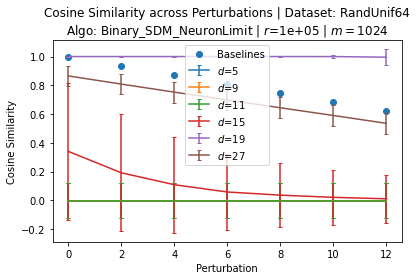

5 [-0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316]
[0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954]
-----
9 [-0.0015604655, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316, -0.0016174316]
[0.12336029, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954, 0.12309954]
-----
11 [0.0042195637, 2.6448568e-05, -0.0012044271, -0.0012207031, -0.0016174316, -0.0016174316, -0.0015563965]
[0.1441167, 0.12947048, 0.12466364, 0.124633394, 0.12309954, 0.12309954, 0.123363435]
-----
15 [0.7040182, 0.41800943, 0.26438192, 0.1618632, 0.096921794, 0.057775877, 0.03189087]
[0.46155939, 0.5003514, 0.45226982, 0.385442, 0.31700113, 0.26034614, 0.21201897]
-----
19 [1.0, 0.99997556, 0.99984336, 0.99863076, 0.9894226, 0.944985, 0.8300822]
[0.0, 0.0010694921, 0.0033698622, 0.017424664, 0.05924833, 0.14894928, 0.2554328]
-----
27 [0.864679, 0.80704755, 0.7513936, 0.6964925, 0.6428528, 0.

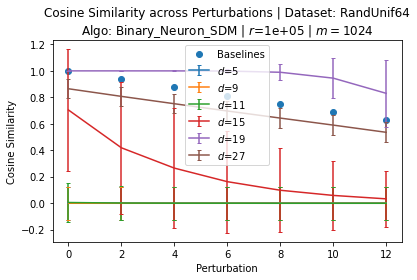

In [6]:
for algo, algo_res in cos_res.items():
    # each is a dictionary i need to homogenize. 
    for nneurons in [r]:
        for h_radius in np.sort(hamm_radii):
            res = algo_res[h_radius][nneurons]
            mu_agg = []
            std_agg = []
            # need to aggregate across these. 
            for pert in perturb_hamms: 
                all_res_for_this_pert = np.asarray(res[pert])
                #plt.hist(all_res_for_this_pert.flatten(), bins=50)
                #plt.show()
                mu, std = all_res_for_this_pert.mean(), all_res_for_this_pert.std()
                mu_agg.append(mu)
                std_agg.append(std)
                
            print(h_radius, mu_agg)
            print(std_agg)
            print('-----')
                
            plt.errorbar(perturb_hamms, mu_agg, yerr=std_agg,capsize=2, label='$d$='+str(h_radius))

        plt.scatter(perturb_hamms, hamm_to_cosine(np.asarray(perturb_hamms), n), label='Baselines')

        if nneurons is None or nneurons == "None": 
            neuron_label = 'Infinite'
        else:
            #print(float(nneurons))
            neuron_label = '$r$='+"{:.0e}".format(nneurons)
        printm= len(trainset) if m is None else m
        
        plt.title("Cosine Similarity across Perturbations"+" | Dataset: "+data_name+"\n"+"Algo: "+algo+" | "+neuron_label+" | $m=$"+str(printm))
        plt.legend()
        plt.xlabel("Perturbation")
        plt.ylabel("Cosine Similarity")
        save_str = "Dataset="+data_name+"|UseCosSim"+str(True)+"m="+str(m)+"r="+str(r)+"Algo="+algo+"|NumNeuron="+neuron_label
        plt.tight_layout()
        plt.gcf().savefig(directory+save_str+'.png', dpi=250)
        plt.show()


# Comparing pairwise distances between vectors in the binary and continuous spaces

For Random Uniform these pairwise distances are very close to each other making comparisons between the algorithms meaningful. This is not the case for MNIST so we only consider its natural continuous settings. 

In [3]:


data_name = "RandUnif64" #"MNIST" "RandUnif64" "RandUnif1000"
m=batch_size=1024 # this is the size of the dataset and also the batch size. Be careful if making m much larger. 

if "MNIST" in data_name:
    image_len = 28
    # generate dataset
    transform = transforms.Compose(
            [transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                            download=True, transform=transform)

    n = image_len**2
    n_base = n
        
elif "RandUnif" in data_name:
    if "64" in data_name:
        n=image_len=64
        n_base = n
        max_perturb = 12
        r = 2**n
        
    elif "1000" in data_name: 
        n=image_len=1000
        n_base = n
        max_perturb = 375
        r = 1000000
    
    trainset = torch.Tensor(np.random.uniform(-1,1,(m*n_datasets,n)))

    
else: 
    raise Exception("Dataset not recognized!")
    
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)


dataiter = iter(trainloader)
patterns = dataiter.next()
if data_name=="MNIST": # get rid of the labels
    patterns = patterns[0] 
patterns = patterns.flatten(start_dim=1).T.to(device) 
# make a binary version of the patterns
b_patterns = (patterns>0.0).type(torch.int)
c_patterns = patterns/torch.norm(patterns, dim=0, keepdim=True)

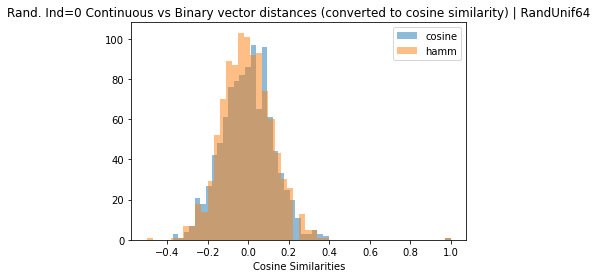

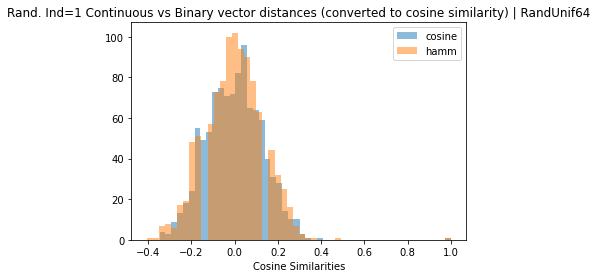

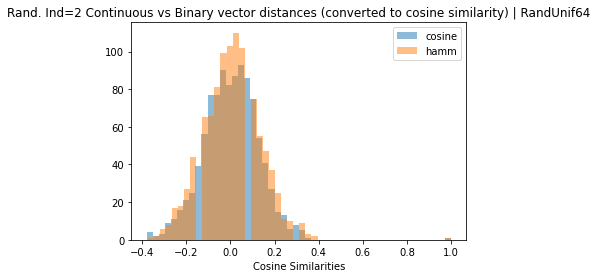

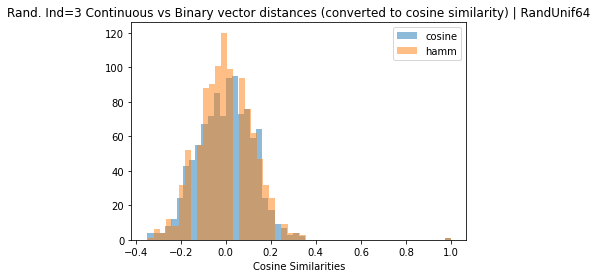

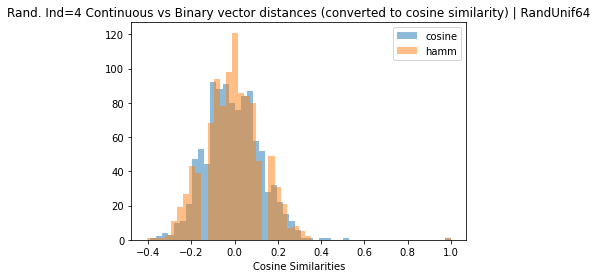

In [6]:
for ind in range(5):
    d_v = torch_hamm_dist(b_patterns[:,ind].unsqueeze(1), b_patterns).cpu().numpy()
    c_v = (c_patterns.T@c_patterns[:,ind]).cpu().numpy()
    plt.hist( c_v ,bins=50, label='cosine', alpha=0.5)
    plt.hist( hamm_to_cosine(d_v, n) ,bins=50, label='hamm', alpha=0.5)
    plt.title("Rand. Ind="+str(ind)+' Continuous vs Binary vector distances (converted to cosine similarity) | '+data_name)
    plt.legend()
    plt.xlabel("Cosine Similarities")
    plt.show()

# Debugging scripts

In [57]:
from SDM_Circ_Inter_Funcs import space_frac_to_hamm_radius
def generate_dataset(pattern_dataset, n, m, max_perturb, cfracs, n_repeats, n_perturbs=6):
    
    target_patterns, ham_dist_queries, cosine_dist_queries = [], [], []
    cosine_perturb_amounts = []
    
    # hamming write distance to use
    
    h_dists = space_frac_to_hamm_radius(n,cfracs)

    if pattern_dataset == "MNIST": 
        image = True
        image_len = 28
        
        transform = transforms.Compose(
            [transforms.ToTensor(), 
             #transforms.Normalize((0.5,), (0.5,))
            ])
        trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                                download=True, transform=transform)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=m,
                                                      shuffle=True, num_workers=0)

        dataiter = iter(trainloader)
        raw_patterns_flat, y_labels = dataiter.next()
        raw_patterns_flat, y_labels = raw_patterns_flat.numpy(), y_labels.numpy()
        print('mnist shape', raw_patterns_flat.shape)
        raw_patterns_flat = raw_patterns_flat.reshape(raw_patterns_flat.shape[0], -1).T
        n = raw_patterns_flat.shape[0]
        if n_perturbs==1:
            perturb_hamms = [max_perturb]
        else: 
            perturb_hamms = list(np.unique(np.linspace(0,max_perturb,n_perturbs).astype(int)))
        # how much to perturb by in terms of hamming distance. 
        #print(perturb_hamms)
        check_if_target_still_closest = False
        # used to keep track of the distances and plot how correlated the space is
        target_dist = []
        closest_dist = []
        same_pattern_class = []
    
    elif pattern_dataset == "RandUnif":
        image=False 
        image_len = None
        # random uniform dist patterns. 

        perturb_hamms = list(set(np.linspace(0,max_perturb,n_perturbs).astype(int))) # how much to perturb by in terms of hamming distance. 
        #perturb_hamms += [190, 195, 200, 210]
        #perturb_hamms = list(np.linspace(0,4500,12).astype(int))
        #perturb_hamms = [3000]

        perturb_hamms = np.sort(perturb_hamms)
        check_if_target_still_closest = True 
        raw_patterns_flat = np.random.uniform(-1,1,(n,m))
        
        target_dist = None
        closest_dist = None
        same_pattern_class = None
    # vector norm all of the patterns. 
    raw_patterns_flat = raw_patterns_flat/ np.linalg.norm(raw_patterns_flat, axis=0)
    
    print('perturbations are:', perturb_hamms)
    # doing binary perturbations here
    for perturb in perturb_hamms:
        for i in range(n_repeats):

            # pick a pattern, perturb it by a given hamming distance from this pattern. 
            # ensure it is still the best match. 
            # see if it converges. 
            # may need to increase the number of iterations!
            target_pattern_ind = np.random.choice(m,1)[0]
            target_pattern = raw_patterns_flat[:, target_pattern_ind ].reshape(-1,1)
            
            ####### Hamming distance perturbation: 
            # flip the sign on these
            hd_query = np.copy(target_pattern)

            if pattern_dataset == 'RandUnif':
                hd_query[np.random.choice(n,perturb, replace=False)]*=-1
            elif pattern_dataset == 'MNIST':
                rand_inds = np.random.choice(n,perturb, replace=False)
                inds_set_to_zero = rand_inds[(hd_query[rand_inds]>0).flatten()]
                inds_set_to_max = rand_inds[(hd_query[rand_inds]==0).flatten()]
                hd_query[ inds_set_to_zero ] = 0
                hd_query[ inds_set_to_max ] = 254
                #query[np.random.choice(n,perturb, replace=False)] = np.random.uniform(0,254,perturb).astype('uint8').reshape(-1,1)

            # ensuring that the query is still closest to the target pattern in similarity and hamming distance. 
            if check_if_target_still_closest:
                assert np.argmax( raw_patterns_flat.T@ hd_query ) == target_pattern_ind, 'original pattern is no longer the best match'
                assert np.argmin( cdist( (raw_patterns_flat>0).astype(bool).T, 
                                        (hd_query>0).astype(int).T, metric='hamming')*n  ) == target_pattern_ind, \
                                            'hamming original pattern is no longer the best match'
            else: 
                pattern_dists = cdist( (raw_patterns_flat>0).astype(bool).T, 
                                        (hd_query>0).astype(int).T, metric='hamming')*n
                closest_pattern_ind = np.argmin( pattern_dists  )
                closest_distance = np.min(pattern_dists)
                
                '''print('Closest pattern is the original', closest_pattern_ind==target_pattern_ind)
                print('closest and target inds', closest_pattern_ind,target_pattern_ind)
                print('hamming distance from query to closest pattern', closest_distance)
                print('perturb is:', perturb)'''
                
                target_dist.append(perturb)
                closest_dist.append(closest_distance)
                same_pattern_class.append( y_labels[closest_pattern_ind]==y_labels[target_pattern_ind]  )
                
            
            ham_dist_queries.append( hd_query )
            
            ######## Cosine distance perturbation:
            cs_perturb = 1-((2*perturb)/n)
            
            # https://stackoverflow.com/questions/52916699/create-random-vector-given-cosine-similarity
            rand_vect = np.random.uniform(-1,1,(n,1))
            target_perp = rand_vect - (rand_vect.T@target_pattern)*target_pattern
            target_perp = target_perp / np.linalg.norm(target_perp, axis=0)
            cs_query = cs_perturb*target_pattern + np.sqrt(1-cs_perturb**2)*target_perp
            #elif pattern_dataset == 'MNIST':
            '''rand_inds = np.random.choice(n,perturb, replace=False)
            inds_set_to_zero = rand_inds[(hd_query[rand_inds]>0).flatten()]
            inds_set_to_max = rand_inds[(hd_query[rand_inds]==0).flatten()]
            hd_query[ inds_set_to_zero ] = 0
            hd_query[ inds_set_to_max ] = 254'''
            #print(cs_query.shape, target_pattern.shape)
            #print('hamm and cosine distances are:',perturb, cs_perturb, 'cs distance is:', cs_query.T@target_pattern)
            
            cosine_dist_queries.append(cs_query)
            cosine_perturb_amounts.append(cs_perturb)
            target_patterns.append( target_pattern )

    # for this n the hamming distance is wrong. 
    print('hdists are:', h_dists)
    for h_dist in h_dists: 
        assert h_dist < n/2, 'need to change h dist.'
        
    ham_dist_queries = np.asarray(ham_dist_queries)
    cosine_dist_queries = np.asarray(cosine_dist_queries)
    return raw_patterns_flat, target_patterns, ham_dist_queries, cosine_dist_queries, perturb_hamms, h_dists, image, image_len, (target_dist, closest_dist, same_pattern_class) 



In [61]:
hamm_radius = 290
perturb = 50
sdm_params.perturb = perturb
num_qs = 5

In [62]:
raw_patterns_flat, target_patterns, \
ham_dist_queries, cosine_dist_queries, \
perturb_hamms, h_dists, image, \
image_len, info  = generate_dataset("MNIST", n, m, 300, 
                                    cfracs, 5, n_perturbs=7)

dataiter = iter(trainloader)

mnist shape (1024, 1, 28, 28)
perturbations are: [0, 50, 100, 150, 200, 250, 300]
hdists are: [290, 308, 314, 331, 345, 374]


In [63]:
len(cosine_dist_queries)

35

In [64]:
target_patterns[10].T @ cosine_dist_queries[10]

array([[0.74489798]])

In [65]:
patterns = dataiter.next()

if data_name=="MNIST": # get rid of the labels
    patterns = patterns[0] 
    print(patterns.shape)
    patterns = patterns.flatten(start_dim=1).T.to(device) 
    print(patterns.shape)
    if "RandUnif" in data_name:
        # make a binary version of the patterns
        b_patterns = (patterns>0.0).type(torch.int)
    else:
        b_patterns = None # MNIST is not working with binary patterns.
    norm_patterns = patterns/torch.norm(patterns, dim=0, keepdim=True)
    new_c_queries, _ = cosine_perturb_queries(norm_patterns, norm_patterns, sdm_params) 
    
    b_cached_inters , new_log_continuous_cached_intersects = get_binary_and_continuous_caches(n, hamm_radius, 
                                                       r, sdm_params.cont_cache_resolution)

torch.Size([1024, 1, 28, 28])
torch.Size([784, 1024])


In [68]:
def update_circle_query(P_a, q, cached_intersects, enforce_num_neurons,
                            intersect_type='FullBinary', resolution=10000):
    """
    Numpy updating of the query using cached circle intersection values. 
    This is called by Continuous_SDM, Pattern_SDM and NeuronLimited_Pattern_SDM.
    
    FullBinary, ContToBinary, FullCont
    
    """
    
    #n, r, m, h_dist, max_iterations, image_len, print_each_result = params 
    if intersect_type=='FullBinary':
        cache_inds =d(P_a, q, n).astype(int)
    elif intersect_type=='ContToBinary':
        dotps = P_a.T@q
        #print(dotps)
        # convert to Hamming distances: 
        cache_inds = np.round(cosine_to_hamm(dotps, n)).astype(int)
        #print(cache_inds)
    elif intersect_type=='FullCont':
        dotps = P_a.T@q
        #plt.hist(dotps.flatten(), bins=50)
        #plt.show()
        cache_inds = ((resolution/2*(dotps + 1))-1).astype(int)
        #print(cache_inds)
    else: 
        raise Exception()
        
    intersects = cached_intersects[cache_inds]
    if enforce_num_neurons: 
        if intersect_type=='FullCont': # need to use log values
            decimals = np.exp(intersects)%1
            one_more_neuron_sample = (np.random.uniform(size=(len(intersects),1))<decimals).astype(float)
            intersects = np.log(np.floor(np.exp(intersects))+one_more_neuron_sample) # need to enforce hard cutoff. 
        else: 
            decimals = intersects%1
            one_more_neuron_sample = (np.random.uniform(size=(len(intersects),1))<decimals).astype(float)
            intersects = np.floor(intersects)+one_more_neuron_sample # need to enforce hard cutoff. 
    
    
    # any intersect that is 0 needs to be ignored to avoid nan errors. the query should just not update at all
    #if np.exp(intersects).sum()==0.0:
    #    return q, None
    
    #print(np.exp(intersects).sum(), 'sum of intersects')
    
    # get pattern weightings
    if intersect_type=='FullCont': 
        # needed as intersects are in log space. 
        unnorm = None #TODO: implement this plotting function if needed.
        res = (np.exp(intersects.T) * P_a).sum(axis=1)/np.exp(intersects).sum()
    else: 
        res = (intersects.T * P_a).sum(axis=1) # broadcasting
        unnorm = np.copy(res)
        res = res/intersects.sum()
        # binarizing.
    if intersect_type=='FullBinary':   
        res = g(res)
    return res, unnorm

sdm_params.hamm_radius=hamm_radius
sdm_params.perturb=perturb
binary_data=False

renorm_query = True
enforce_num_neurons = False

old_dataset = False
old_algo = True

if old_dataset: 
    c_patterns = raw_patterns_flat 
    c_targets = np.asarray(target_patterns[10:15]).reshape(num_qs, -1).T
    c_queries = np.asarray(cosine_dist_queries[10:15]).reshape(num_qs, -1).T
    print('old d', c_queries.shape)
    
else:
    c_patterns = norm_patterns.cpu().numpy()
    c_queries = new_c_queries.cpu().numpy()
    c_targets = c_patterns[:,:num_qs]
                    
# get this query to converge:

resolution = 10000
cs_intervals = np.linspace(-1,1,resolution).astype(float)
cs_intervals[-1] = cs_intervals[-1] - 1e-15

if enforce_num_neurons: 
    log_continuous_cached_intersects = cap_intersection(n, cs_intervals, hamm_radius, r, 
                                                    return_log=True,
                                                    ham_input=False, print_oobs=False)
else: 
    log_continuous_cached_intersects = cap_intersection(n, cs_intervals, hamm_radius, r, 
                                                    return_log=True,
                                                    ham_input=False, print_oobs=False)


converged_queries = []

for query_ind in range(num_qs):
    #print("processing query number:", query_ind)
    query = np.copy(c_queries[:,query_ind]).reshape(-1,1)

    bits_changed = 100 # placeholder to be able to track convergence.
    i = 0
    while bits_changed > 0 and i<sdm_params.max_conv_steps:
        
        if old_algo: 

            new_query, pre_bin = update_circle_query(c_patterns, 
                                                     query, log_continuous_cached_intersects,  
                                                         enforce_num_neurons, 
                                                         intersect_type="FullCont", resolution=resolution)
        
        else: 
            new_query = update_using_cache(torch.Tensor(c_patterns).to(device), torch.Tensor(c_patterns).to(device), 
                                        torch.Tensor(new_log_continuous_cached_intersects.astype(float)).to(device), enforce_num_neurons,
                            "FullCont", device, torch.Tensor(query).to(device), full_dim_queries = None)
            new_query = new_query.cpu().numpy()
        
        
        new_query = new_query.reshape(-1, 1)
        #print(query, new_query)
        epsilon = 0.05
        bits_agree = np.logical_and(query-epsilon < new_query , 
                             query+epsilon > new_query).sum()
        bits_changed = n-bits_agree
        query=new_query
        i+=1
        
        if renorm_query:
            query = query/np.linalg.norm(query)

    converged_queries.append(query)
    print('num convergence steps', i)

converged_queries = np.asarray(converged_queries).reshape(num_qs, -1).T

print(converged_queries.shape,c_queries[:,:num_qs].shape )

if binary_data:
    cosine_sims = hamm_to_cosine( (converged_queries!=c_patterns).sum(0), n_base ).cpu().detach().numpy()
else:
    cosine_sims = (converged_queries/np.linalg.norm(converged_queries, axis=0)*c_targets/np.linalg.norm(c_targets, axis=0)).sum(0)
print("cosine sims are:", cosine_sims, sum(cosine_sims)/len(cosine_sims))


num convergence steps 1
num convergence steps 1
num convergence steps 1
num convergence steps 1
num convergence steps 1
(784, 5) (784, 5)
cosine sims are: [0.99878295 0.99820816 0.99686641 0.99606364 0.9999311 ] 0.9979704495889543


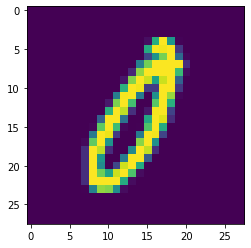

perturb amount 0.87244904


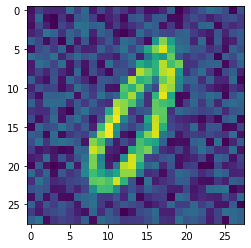

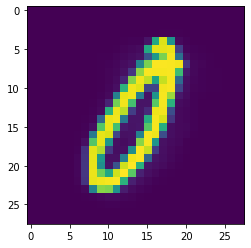

In [67]:
plt.imshow(c_targets[:,0].reshape(image_len, image_len))
plt.show()
print('perturb amount', c_targets[:,0].T@c_queries[:,0])
plt.imshow(c_queries[:,0].reshape(image_len, image_len))
plt.show()
plt.imshow(converged_queries[:,0].reshape(image_len, image_len))
plt.show()